### 1. Introduction

We have been tasked with selecting popular recipes for the homepage to boost website traffic and subscriptions. The current method of relying on personal preference has produced inconsistent results. To address this, we developed binary classification models using Random Forest and Logistic Regression to predict whether a recipe will generate high or low traffic. The models have demonstrated promising performance.


### 2. Data Validation

**All columns have been validated.**

- No duplicates were found. (Status: Confirmed)
- All recipes (and their IDs) are unique. (Status: Confirmed)
- All numerical columns contain non-negative values. (Status: Confirmed)
- Target variable (high_traffic) and Category feature are in character format. (Status: Confirmed)
- Target variable "high_traffic" has been renamed to "traffic" for clarity. (Status: Confirmed)
- Invalid category value in the Category feature – "Chicken Breast". (Observation: Issue)  
  - Resolution: This value was merged with the category "Chicken".
- Invalid data type in the Servings feature – initially encoded as character instead of numeric. (Observation: Issue)
- Invalid values in the Servings feature – encountered values "4 as a snack" and "6 as a snack". (Observation: Issue)  
  - Resolution: These values were merged with "4" and "6" respectively, then converted to numeric type.
- Missing values in the target variable (traffic) were identified. (Observation: Issue)  
  - Resolution: Missing values were replaced with 'Low'.
- Recipe ID column was dropped from the dataset since it would not contribute any useful information for modeling. (Status: Confirmed)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

Loading the data from the CSV file

In [3]:
## Load the dataset
df_recipes = pd.read_csv('./recipe_site_traffic_2212.csv')

Displaying the first 5 rows of the dataset
- we can see some missing values in the dataset
- the data contain 7 columns and 957 rows

In [4]:
df_recipes

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


In [5]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


Duplicate check on the dataset, no duplicates found

In [6]:
print(df_recipes.duplicated().sum())

0


In [7]:
print(df_recipes.duplicated(subset = df_recipes.drop('high_traffic',axis=1).columns).sum())

0


Renamed high_traffic to traffic for clarity.

In [8]:
df_recipes.rename(columns={'high_traffic': 'traffic'}, inplace=True)
df_recipes.columns

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'traffic'],
      dtype='object')

In [9]:
def check_dtype(df: pd.DataFrame, column: str, expected_dtype: str) -> None:
    dtype_checkers = {
        'numeric': pd.api.types.is_numeric_dtype,
        'character': pd.api.types.is_string_dtype
    }
    
    if expected_dtype not in dtype_checkers:
        raise ValueError(f"Invalid dtype '{expected_dtype}'. Expected 'numeric' or 'character'.")
    
    if dtype_checkers[expected_dtype](df[column]):
        print(f'✅ The column "{column}" matches the expected dtype: {expected_dtype}.')
    else:
        actual_dtype = 'character' if df[column].dtype == 'O' else 'numeric'
        print(f'❌ The column "{column}" does not match the expected dtype. It is actually {actual_dtype}.')

##### Recipe
Checking if the recipe column is numeric as per the validation description.
- The recipe column is numeric.

Checking if all values in the recipe column are unique, as per the validation description.
- All values in the recipe column are unique.

In [10]:
check_dtype(df_recipes, 'recipe', 'numeric')

✅ The column "recipe" matches the expected dtype: numeric.


In [11]:
assert df_recipes['recipe'].nunique() == df_recipes.shape[0]

#### Calories
Checking if the calories column is numeric as per the validation description.

- The calories column is numeric.

Checking if all calories values are positive, as calories cannot be negative.

- All values in the calories column are positive.

In [12]:
check_dtype(df_recipes, 'calories', 'numeric')

✅ The column "calories" matches the expected dtype: numeric.


In [13]:
assert df_recipes['calories'].min() >= 0.0

#### Carbohdrate
Checking if the carbohydrate column is numeric as per the validation description.
- The carbohydrate column is numeric.

Checking if all values in the carbohydrate column are positive, as it represents an amount that cannot be negative.
- All values in the carbohydrate column are positive.

In [14]:
check_dtype(df_recipes, 'carbohydrate', 'numeric')

✅ The column "carbohydrate" matches the expected dtype: numeric.


In [15]:
assert df_recipes['carbohydrate'].min() >= 0.0

#### Sugar

- Checking if the *sugar* column is numeric as per the validation description.  
  - The *sugar* column is numeric.  

- Checking if all values in the *sugar* column are positive, as they represent weight amounts that cannot be negative.  
  - All values in the *sugar* column are positive.  


In [16]:
check_dtype(df_recipes, 'sugar', 'numeric')

✅ The column "sugar" matches the expected dtype: numeric.


In [17]:
assert df_recipes['sugar'].min() >= 0.0

#### Protein

Checking if the *protein* column is numeric as per the validation description.  
  - The *protein* column is numeric.  

Checking if all values in the *protein* column are positive, as they represent weight amounts that cannot be negative.  
  - All values in the *protein* column are positive.  


In [18]:
check_dtype(df_recipes, 'protein', 'numeric')

✅ The column "protein" matches the expected dtype: numeric.


In [19]:
assert df_recipes['protein'].min() >= 0.0

#### Category

Checking if the *category* column is of type character as per the validation description.  
  - The *category* column is character-based.

In [20]:
check_dtype(df_recipes, 'category', 'character')

✅ The column "category" matches the expected dtype: character.


Checking if all values in the *category* column belong to the valid categories as per the validation description.  

  **Valid categories:**  
  - Lunch/Snacks  
  - Beverages  
  - Potato  
  - Vegetable  
  - Meat  
  - Chicken  
  - Pork  
  - Dessert  
  - Breakfast  
  - One Dish Meal 

In [21]:
valid_categories = ['Lunch/Snacks', 'Beverages', 'Potato','Vegetable', 'Meat',
                    'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal']
valid_categories

['Lunch/Snacks',
 'Beverages',
 'Potato',
 'Vegetable',
 'Meat',
 'Chicken',
 'Pork',
 'Dessert',
 'Breakfast',
 'One Dish Meal']

And these are the categories found in the provided data:

In [22]:
actual_categories = sorted(df_recipes['category'].value_counts(dropna = False).index.tolist())
actual_categories

['Beverages',
 'Breakfast',
 'Chicken',
 'Chicken Breast',
 'Dessert',
 'Lunch/Snacks',
 'Meat',
 'One Dish Meal',
 'Pork',
 'Potato',
 'Vegetable']

As can be seen, there is one invalid category: "Chicken Breast".


In [23]:
invalid_categories = list(set(valid_categories) - set(actual_categories)) +\
                     list(set(actual_categories) - set(valid_categories))

invalid_categories

['Chicken Breast']

Since "Chicken Breast" is apparently a type of "Chicken", we replace all occurrences of "Chicken Breast" with "Chicken".


In [24]:
df_recipes['category'] = df_recipes['category'].replace('Chicken Breast', 'Chicken')
df_recipes['category'].value_counts(dropna = False)

category
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Dessert           83
Vegetable         83
Meat              79
One Dish Meal     71
Name: count, dtype: int64

#### Servings

Check whether the servings column is numeric according to the validation description.

As can be seen, the servings values are encoded as characters instead of numeric. Therefore, we need to convert these values into numerical ones, specifically into integers.


In [25]:
check_dtype(df_recipes, 'servings', 'numeric')

❌ The column "servings" does not match the expected dtype. It is actually character.


We also need to validate its categories—if the traffic to the site was high when such a recipe was shown, it should be labeled as **"High"**.

That is indeed true, but for further operations, we need to treat the missing values. Since they indicate that the traffic was not high, we impute such missing values with the category **"Low"**.



In [26]:
df_recipes['traffic'].value_counts(dropna = False)

traffic
High    574
NaN     373
Name: count, dtype: int64

In [27]:
df_recipes['traffic'] = df_recipes['traffic'].fillna('Low')
df_recipes['traffic'].value_counts(dropna = False)

traffic
High    574
Low     373
Name: count, dtype: int64

#### Servings

Check whether the servings column is numeric according to the validation description.

As can be seen, the servings values are encoded as characters instead of numeric. Therefore, we need to convert these values into numerical ones, specifically into integers.

Before any conversion, we need to check its unique values.

As can be seen, besides the numerical values, there are two values that contain text—namely, "4 as a snack" and "6 as a snack". 

One might argue that these should be treated as separate/different values, but since their frequencies sum up to only three observations, we merge these values with their respective numerical values—"4 as a snack" with "4" and "6 as a snack" with "6". 

We also convert these character values into numerical ones using list comprehension.


In [28]:
df_recipes['servings'].value_counts(dropna = False)

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [29]:
df_recipes['servings'] = [int(i[0]) if isinstance(i, str) and len(i) > 1 else int(i) for i in df_recipes['servings']]
df_recipes.servings.value_counts(dropna = False)

servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64

Let us check the data type again—after these operations, the column is indeed numeric.


In [30]:
check_dtype(df_recipes, 'servings', 'numeric')

✅ The column "servings" matches the expected dtype: numeric.


#### Traffic

Check whether the `high_traffic` column is character according to the validation description. (It is indeed.)


In [31]:
check_dtype(df_recipes, 'traffic', 'character')

✅ The column "traffic" matches the expected dtype: character.


#### Other Cleaning Tasks

Since the `recipe` column is just an ID column and doesn't capture any useful information for modeling, we drop it from the data.

Additionally, we set other parameters beforehand, such as the random seed, target variable name, and lists of categorical/numeric features for further operations.


In [32]:
df_recipes.drop('recipe', axis = 1, inplace = True, errors = 'ignore')

target = 'traffic'
cat_features = [i for i in df_recipes.columns if df_recipes[i].dtype == 'O' and i != target]
num_features = [i for i in df_recipes.columns if i not in cat_features and i != target]

print(f'Target variable: {target}')
print(f'Categorical features: {", ".join(cat_features)}')
print(f'Numerical features: {", ".join(num_features)}')

cat = cat_features[0]

Target variable: traffic
Categorical features: category
Numerical features: calories, carbohydrate, sugar, protein, servings


In [33]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   traffic       947 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 51.9+ KB


##### Exploratory Data Analysis (EDA) Summary

- **Dataset Overview:**
  - 957 rows and 17 columns.
  - Recipe IDs dropped; 'high_traffic' renamed to 'traffic'.

- **Data Preparation:**
  - Converted 'category', 'traffic', and 'servings' to categorical types.
  - Addressed invalid entries in category (merged "Chicken Breast" with "Chicken") and servings (merged "4 as a snack"/"6 as a snack" into "4"/"6" and converted to numeric).

- **Missing Values:**
  - 52 missing values (≈5.4%) in calories, carbohydrate, sugar, and protein (all in the same rows).
  - Decision: Remove these 52 rows (given the low impact and weak associations).

- **Outlier Handling:**
  - Applied the IQR method to detect and remove outliers from numeric variables.

- **Traffic & Feature Insights:**
  - Target variable "traffic" is unbalanced: ~60% High vs. 40% Low.
  - Numeric insights: slight positive correlation between protein & calories; slight negative correlation between protein & sugar.
  - Category insights: Chicken most common; One Dish Meal least common.
  - Servings insights: 4 servings is the most frequent, reflecting higher traffic for 4-serving recipes.

##### Data Preparation for Modeling

The 'category', 'traffic', and 'servings' features were converted to a categorical data type. This conversion enables the models to effectively handle discrete values and can lead to improved accuracy.

In [34]:
# Convert selected columns to categorical type, if they exist in the DataFrame
for col in ['category', 'traffic', 'servings']:
    if col in df_recipes.columns:
        df_recipes[col] = df_recipes[col].astype('category')
    else:
        print(f"Column '{col}' not found in df_recipes.")

In [35]:
df_recipes.head(10)
print(df_recipes.dtypes)
print(df_recipes.shape)
print(df_recipes.describe())
value_counts = df_recipes['traffic'].value_counts()
percentage = 100.0 * value_counts / value_counts.sum()

calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings        category
traffic         category
dtype: object
(947, 7)
          calories  carbohydrate       sugar     protein
count   895.000000    895.000000  895.000000  895.000000
mean    435.939196     35.069676    9.046547   24.149296
std     453.020997     43.949032   14.679176   36.369739
min       0.140000      0.030000    0.010000    0.000000
25%     110.430000      8.375000    1.690000    3.195000
50%     288.550000     21.480000    4.550000   10.800000
75%     597.650000     44.965000    9.800000   30.200000
max    3633.160000    530.420000  148.750000  363.360000


#### Handling Missing Values for Numeric Features

- **Overview:**
  - Total dataset: 957 rows.
  - There are 4 features with missing values: *calories*, *carbohydrate*, *sugar*, and *protein*.
  - Each of these features has 52 missing values, and all missingness occurs on the same 52 recipes.

- **Analysis:**
  - The missingness in these numeric features is isolated to the same 52 observations (approximately 5.4% of the dataset).
  - Frequency tables and association metrics (e.g., Phi coefficient and Cramer's V) indicate that the missing values are weakly associated with the target and category variables.

- **Recommendation:**
  - **Removing the 52 rows** is a valid and efficient solution given the low proportion of missing data (5.4%) and the weak association with other variables.


In [36]:
# check missing values trend and percentage
missing = df_recipes.isnull().sum()
missing = missing[missing > 0]
missing_percentage = 100 * missing / df_recipes.shape[0]
missing_info = pd.DataFrame({
    'missing_values': missing,
    'missing_percentage': missing_percentage
})
missing_info = missing_info.sort_values(by='missing_percentage', ascending=False)
print(missing_info)


              missing_values  missing_percentage
calories                  52            5.491024
carbohydrate              52            5.491024
sugar                     52            5.491024
protein                   52            5.491024


In [37]:
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = sp.stats.chi2_contingency(confusion_matrix.values)
    n = confusion_matrix.values.sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

# List of numeric features with missing values
features_with_missing = ['calories', 'carbohydrate', 'sugar', 'protein']

for feature in features_with_missing:
    # Create a binary indicator: 1 if the value is missing, 0 otherwise.
    missing_indicator = df_recipes[feature].isna().astype(int)
    
    # Association with the target variable 'traffic'
    ct_target = pd.crosstab(missing_indicator, df_recipes[target])
    cv_target = cramers_v(ct_target)
    
    # Association with the 'category' variable
    ct_category = pd.crosstab(missing_indicator, df_recipes['category'])
    cv_category = cramers_v(ct_category)
    
    print(f"Feature: {feature}")
    print("Frequency Table with Traffic:")
    print(ct_target)
    print(f"Cramer's V with Traffic: {cv_target:.3f}")
    print("\nFrequency Table with Category:")
    print(ct_category)
    print(f"Cramer's V with Category: {cv_category:.3f}")
    print("-" * 50)

Feature: calories
Frequency Table with Traffic:
traffic   High  Low
calories           
0          535  360
1           39   13
Cramer's V with Traffic: 0.066

Frequency Table with Category:
category  Beverages  Breakfast  Chicken  Dessert  Lunch/Snacks  Meat  \
calories                                                               
0                92        106      163       77            82    74   
1                 0          0        9        6             7     5   

category  One Dish Meal  Pork  Potato  Vegetable  
calories                                          
0                    67    73      83         78  
1                     4    11       5          5  
Cramer's V with Category: 0.154
--------------------------------------------------
Feature: carbohydrate
Frequency Table with Traffic:
traffic       High  Low
carbohydrate           
0              535  360
1               39   13
Cramer's V with Traffic: 0.066

Frequency Table with Category:
category      Beverage

In [38]:
# # remove missing values
df_recipes.dropna(inplace=True)

In [39]:
print(df_recipes.isna().sum())

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
traffic         0
dtype: int64


#### Handling outliers
Using IQR method to detect and remove outliers from the numeric columns, for better model performance as the outliers can affect the model's accuracy.

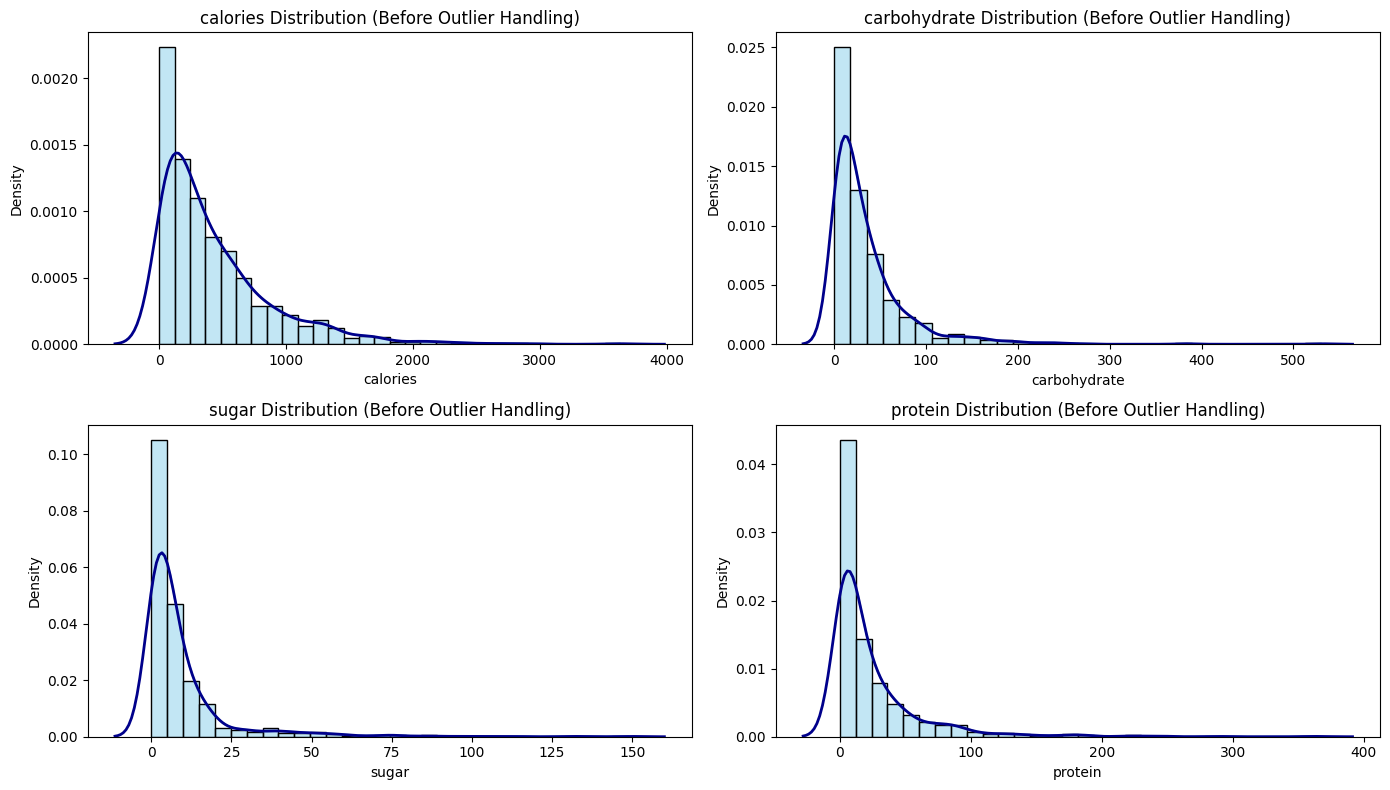

In [40]:
# Ensure df_before_outlier is defined
if 'df_before_outlier' not in globals():
    df_before_outlier = df_recipes.copy()

# Get numeric columns from the original DataFrame (before outlier handling)
numeric_cols_orig = df_before_outlier.select_dtypes(include=["float64", "int64"]).columns
n = len(numeric_cols_orig)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(14, nrows * 4))
axes = axes.ravel()

for i, col in enumerate(numeric_cols_orig):
    sns.histplot(df_before_outlier[col], kde=True, stat="density", bins=30,
                 color="skyblue", edgecolor="black", ax=axes[i])
    sns.kdeplot(df_before_outlier[col], color="darkblue", lw=2, ax=axes[i])
    axes[i].set_title(f'{col} Distribution (Before Outlier Handling)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
 
plt.tight_layout()
plt.show()

In [41]:
# Outlier Handling using IQR
df_before_outlier = df_recipes.copy()

def handle_outlier(df, col):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    iqr_value = Q3 - Q1
    upper = Q3 + (1.5 * iqr_value)
    lower = Q1 - (1.5 * iqr_value)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

df_numeric = df_recipes.select_dtypes(include=["float64", "int64"])
for column in df_numeric.columns:
    handle_outlier(df_recipes, column)

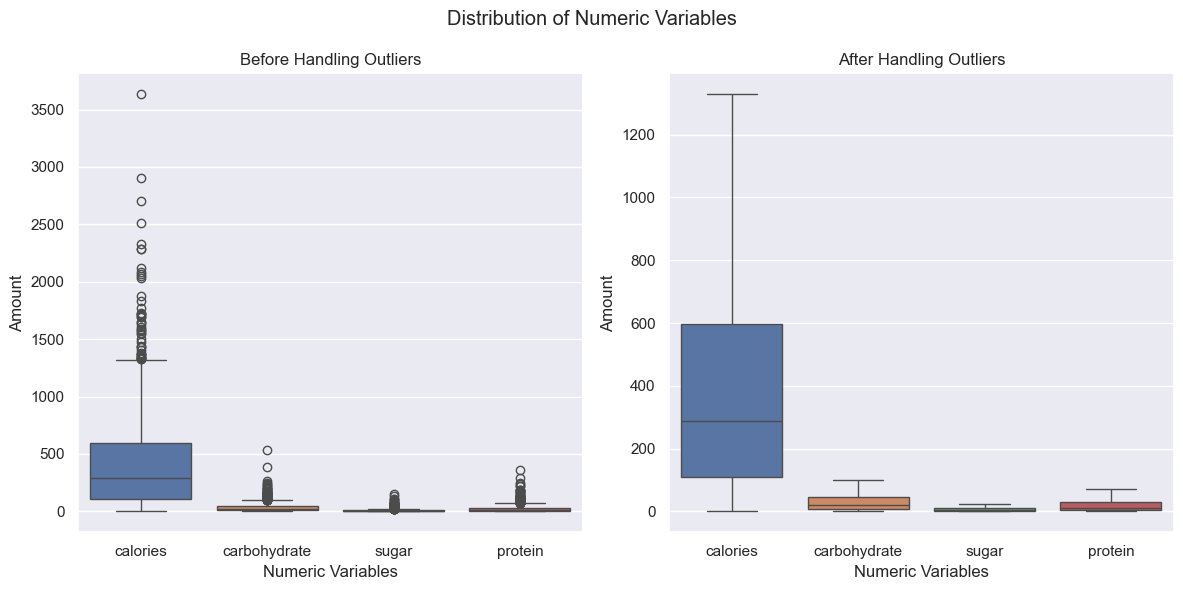

In [42]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(df_before_outlier, ax=axes[0])
sns.boxplot(df_recipes, ax=axes[1])
axes[0].set_title("Before Handling Outliers")
axes[1].set_title("After Handling Outliers")
fig.suptitle("Distribution of Numeric Variables")
axes[0].set_xlabel("Numeric Variables")
axes[1].set_xlabel("Numeric Variables")
axes[0].set_ylabel("Amount")
axes[1].set_ylabel("Amount")
plt.tight_layout()
plt.show()

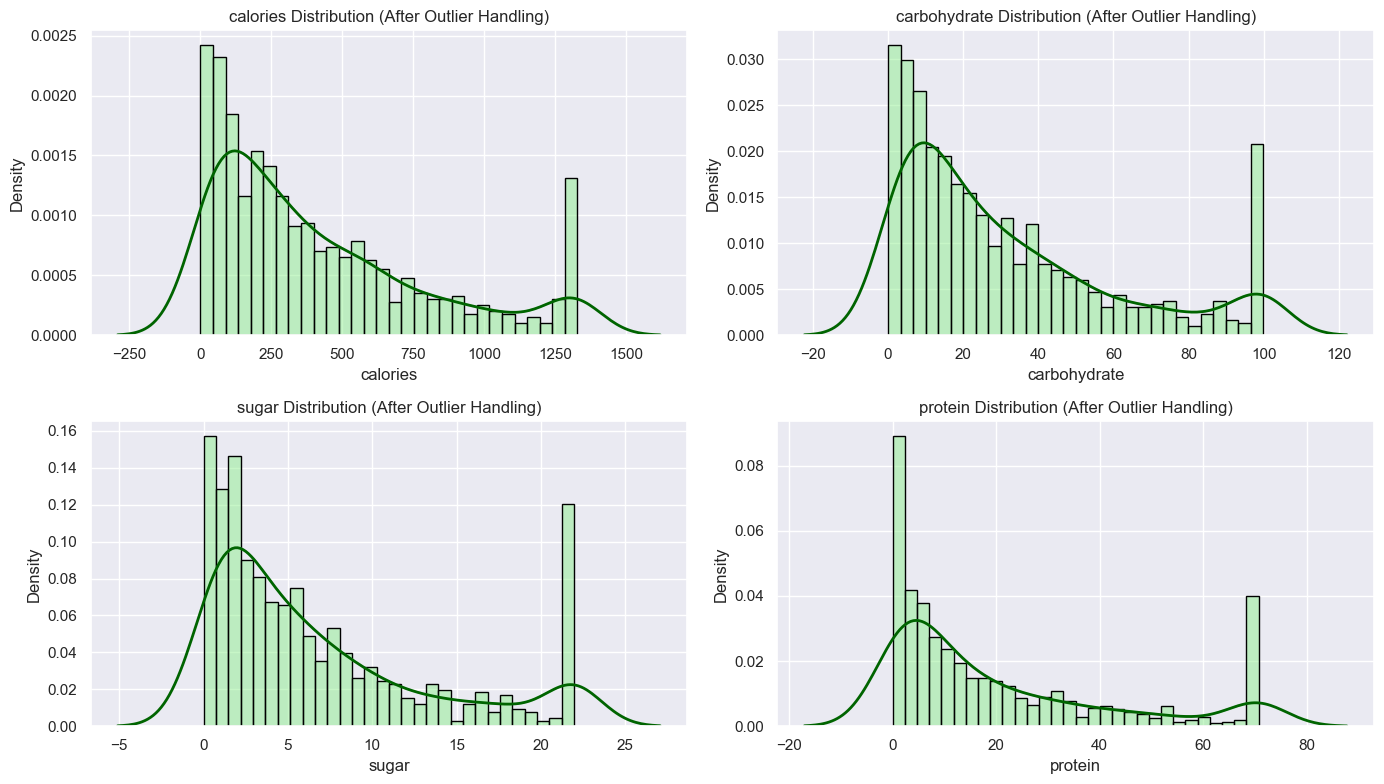

In [43]:
# Histograms and KDE Plots After Outlier Handling
numeric_cols = df_numeric.columns
n = len(numeric_cols)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(14, nrows * 4))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    sns.histplot(df_recipes[col], kde=True, stat="density", bins=30, 
                 color="lightgreen", edgecolor="black", ax=axes[i])
    sns.kdeplot(df_recipes[col], color="darkgreen", lw=2, ax=axes[i])
    axes[i].set_title(f'{col} Distribution (After Outlier Handling)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Since our goal is to predict which recipes will attract visitors, we have chosen the "traffic" variable as our target. The chart below shows that the dataset is unbalanced; approximately 59.8% of the recipes are labeled as "High" traffic and 40.2% as "Low" traffic.

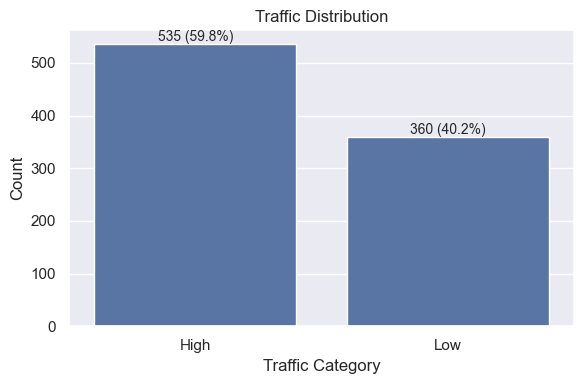

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='traffic', data=df_recipes, ax=ax)
total = len(df_recipes)

for patch in ax.patches:
    count = patch.get_height()
    percent = (count / total) * 100
    x_pos = patch.get_x() + patch.get_width() / 2
    y_pos = count
    ax.text(x_pos, y_pos, f'{int(count)} ({percent:.1f}%)', ha='center', va='bottom', fontsize=10)

ax.set_title('Traffic Distribution')
ax.set_xlabel('Traffic Category')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

The numeric variables in the dataset are calories, carbohydrate, sugar, and protein. The heatmap reveals a low positive correlation of 0.20 between protein and calories, indicating that recipes with slightly higher protein content may have more calories. Additionally, there is a small negative correlation of -0.10 between protein and sugar, suggesting that as the protein content increases, the sugar content tends to decrease slightly.

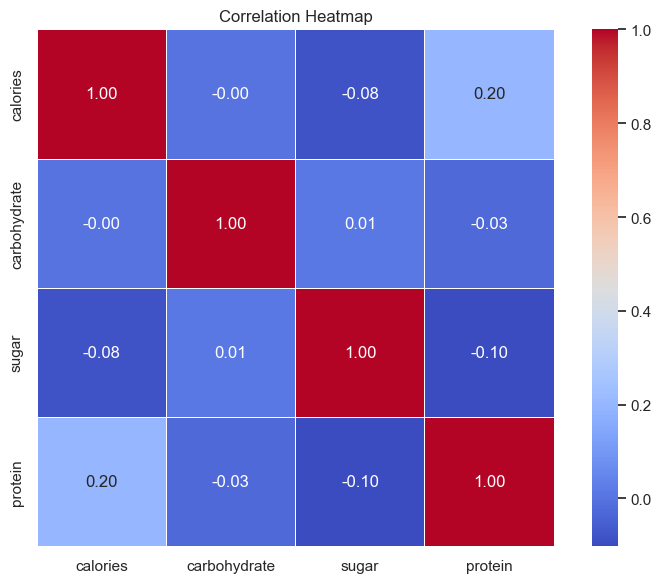

In [45]:
# Correlation Heatmap
cat_cols = df_recipes.select_dtypes(exclude=['number']).columns
df_numeric = df_recipes.drop(columns=cat_cols)
corr_matrix = df_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm', square=True, linecolor='white')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

The jointplot shows the relationship between calories and protein in recipes. Using a scatter plot with purple markers and white edges, it makes it easy to see how protein levels vary with calorie counts.

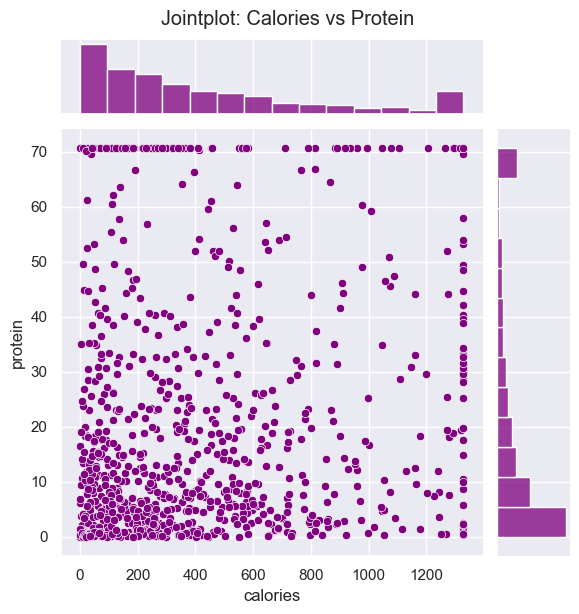

In [46]:
## Additional Visualization: Jointplot for Key Variables
sns.jointplot(data=df_recipes, x='calories', y='protein', kind='scatter', color='purple', edgecolor='w', height=6)
plt.suptitle('Jointplot: Calories vs Protein', y=1.02)
plt.show()

The bar plots compare each numeric variable with the traffic target. Recipes with 'high' traffic tend to have more calories, carbohydrate, and protein, while those with 'low' traffic usually have more sugar.

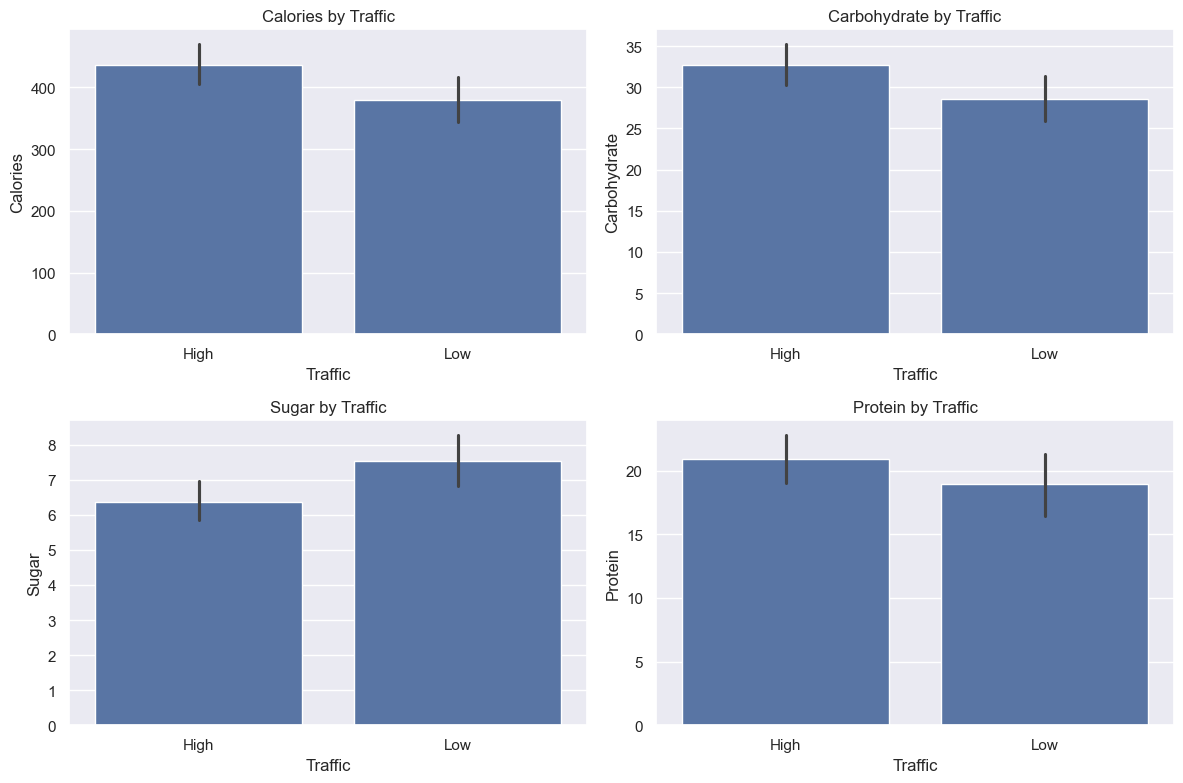

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
features = ['calories', 'carbohydrate', 'sugar', 'protein']

for ax, feature in zip(axs.flatten(), features):
    sns.barplot(data=df_recipes, x='traffic', y=feature, ax=ax)
    ax.set_title(f"{feature.title()} by Traffic")
    ax.set_xlabel("Traffic")
    ax.set_ylabel(feature.title())

plt.tight_layout()
plt.show()

The pair plot shows the relationships among calories, carbohydrate, sugar, and protein. It helps us spot trends and possible outliers between each pair of variables.

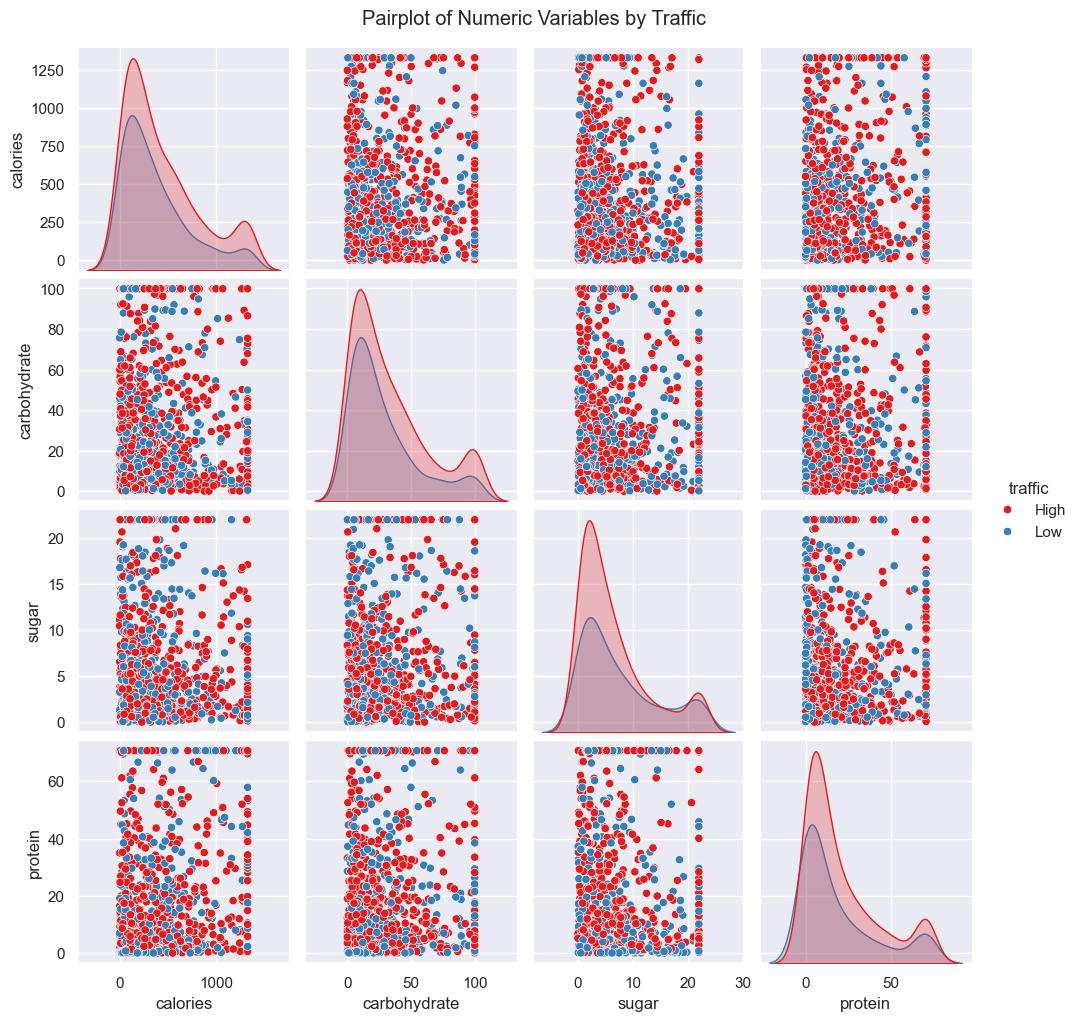

In [48]:
sns.pairplot(data=df_recipes, hue="traffic", palette="Set1", diag_kind="kde")
plt.suptitle("Pairplot of Numeric Variables by Traffic", y=1.02)
plt.show()

##### Recipe Category Distribution  
**Chicken** is the most common category with **163 recipes**, followed by **Breakfast (106)**, **Beverages (92)**, and **Potato (83)**. The least common category is **One Dish Meal (67)**, indicating lower interest or fewer available recipes in that segment.  

##### Number of Recipes by Servings  
The most frequent serving size is **4 servings (367 recipes)**, suggesting that most recipes cater to small groups or families. Other common serving sizes include **6 servings (185)**, **2 servings (174)**, and **1 serving (169)**.  

##### Traffic Distribution by Category  
There is a noticeable trend where some categories consistently receive **higher traffic**, such as **Chicken (69 High, 94 Low)** and **Breakfast (73 High, 33 Low)**, while others, like **Beverages (5 High, 87 Low)** and **Pork (7 High, 66 Low)**, have more recipes with **low traffic**. This indicates that certain food categories attract more audience engagement.  

##### Traffic Distribution by Servings  
The **4-serving recipes** have the **highest traffic**, with **220 high-traffic instances** and **147 low-traffic instances**, followed by **6-serving recipes (118 high, 67 low)**. **Single-serving recipes (99 high, 70 low)** and **two-serving recipes (98 high, 76 low)** receive comparatively lower engagement, implying that larger portion recipes tend to be more popular.  


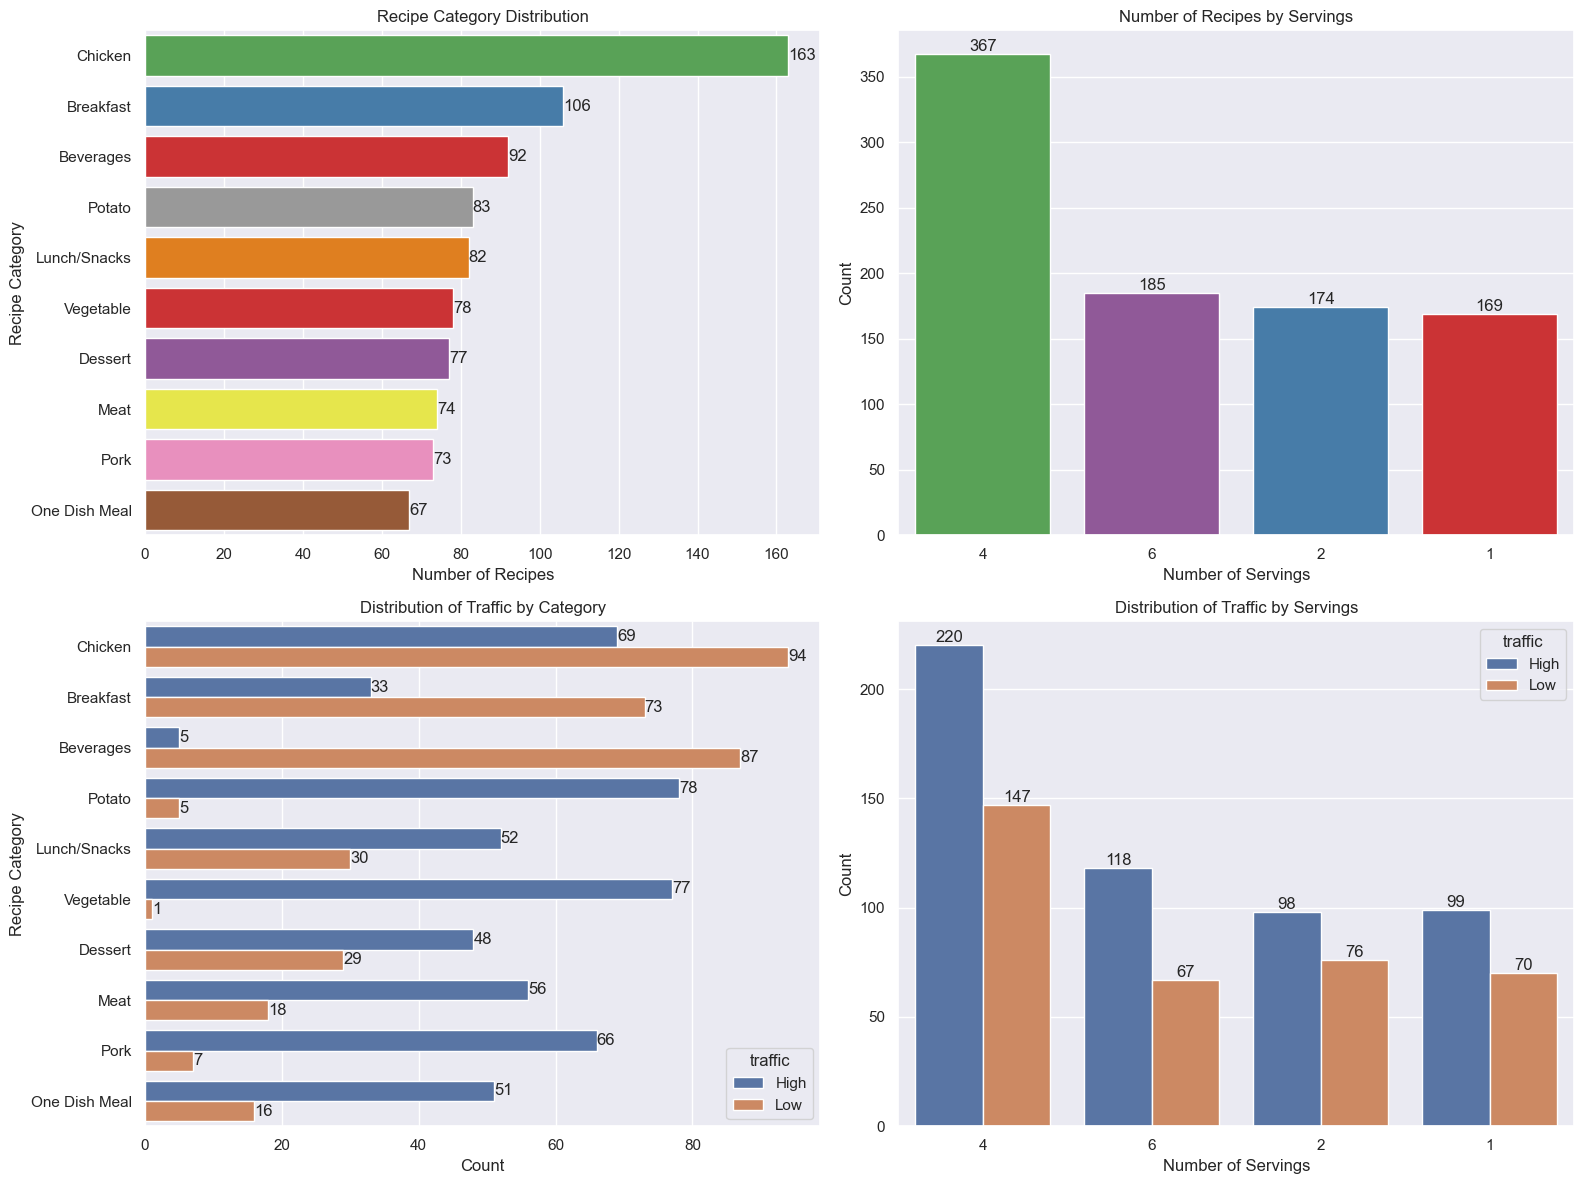

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Recipe Category Distribution (Count by category with hue = category)
sns.countplot(y='category', data=df_recipes, hue='category', palette="Set1",
              order=df_recipes['category'].value_counts().index, ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Recipe Category Distribution')
axes[0, 0].set_xlabel('Number of Recipes')
axes[0, 0].set_ylabel('Recipe Category')
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, label_type='edge')

# Plot 2: Number of Recipes by Servings (Count by servings with hue = servings)
sns.countplot(x='servings', data=df_recipes, hue='servings', palette="Set1",
              order=df_recipes['servings'].value_counts().index, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Number of Recipes by Servings')
axes[0, 1].set_xlabel('Number of Servings')
axes[0, 1].set_ylabel('Count')
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, label_type='edge')

# Plot 3: Distribution of Traffic by Category (Count by category with hue = traffic)
sns.countplot(data=df_recipes, y="category", hue="traffic",
              order=df_recipes['category'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Traffic by Category')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Recipe Category')
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, label_type='edge')

# Plot 4: Distribution of Traffic by Servings (Count by servings with hue = traffic)
sns.countplot(x='servings', data=df_recipes, hue="traffic",
              order=df_recipes['servings'].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Traffic by Servings')
axes[1, 1].set_xlabel('Number of Servings')
axes[1, 1].set_ylabel('Count')
for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, label_type='edge')

plt.tight_layout()
plt.show()

## Model Fitting

**Predictive Modeling for High Traffic Levels**

Predicting high traffic is treated as a binary classification challenge. Initially, Logistic Regression was chosen for its simplicity, computational efficiency, and easily interpretable feature weightings. However, empirical testing revealed that Logistic Regression slightly outperforms the Random Forest model. With a test accuracy of about 83% and an AUC of 0.88, Logistic Regression offers stronger predictive accuracy and transparency, providing extra confidence when forecasting high-traffic recipes.

**Data Preparation for Modeling**

For the predictive modeling, the following features were selected: calories, carbohydrate, sugar, protein, servings, and category, while traffic serves as the target variable. The data preparation process included:

- **Encoding Categorical Features:** Transforming non-numeric data into a suitable numerical format.
- **Scaling Numerical Features:** Standardizing the numeric variables for a consistent scale.
- **Enhancements:** Incorporating a standard deviation (std) column among the numerical features to boost model performance.

The finalized dataset consists of 895 rows and 17 columns. The data was partitioned into training and testing sets, with 80% allocated for training and 20% reserved for testing.

In [50]:
df_recipes['servings'] = df_recipes['servings'].astype('int')
df_recipes = pd.get_dummies(df_recipes, columns=['category'])
label_encoder = LabelEncoder()
df_recipes['traffic'] = label_encoder.fit_transform(df_recipes['traffic'])

columns_for_std = ['calories', 'carbohydrate', 'sugar', 'protein']
df_recipes['std'] = df_recipes[columns_for_std].apply(lambda row: np.std(row), axis=1)

column_order = [
    'calories', 'carbohydrate', 'sugar', 'protein', 'std', 'servings',
    'category_Beverages', 'category_Breakfast', 'category_Chicken',
    'category_Dessert', 'category_Lunch/Snacks',
    'category_Meat', 'category_One Dish Meal', 'category_Pork',
    'category_Potato', 'category_Vegetable', 'traffic'
]
df_recipes = df_recipes[column_order]

df_recipes.head()

,calories,carbohydrate,sugar,protein,std,servings,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,traffic
1,35.48,38.56,0.660,0.92,18.147933,4,False,False,False,False,False,False,False,False,True,False,0
2,914.28,42.68,3.090,2.88,389.210353,1,False,True,False,False,False,False,False,False,False,False,1
3,97.03,30.56,21.965,0.02,36.187104,4,True,False,False,False,False,False,False,False,False,False,0
4,27.05,1.85,0.800,0.53,11.264798,4,True,False,False,False,False,False,False,False,False,False,1
5,691.15,3.46,1.650,53.93,291.511236,2,False,False,False,False,False,False,True,False,False,False,0


In [51]:
X = df_recipes.drop(["traffic"], axis=1).values
y = df_recipes["traffic"].values
print("X shape:", X.shape, "y shape:", y.shape)

numeric_features = X[:, :5]
st_scaler = StandardScaler()
st_scaler.fit(numeric_features)
scaled_numeric = st_scaler.transform(numeric_features)
X_scaled = np.concatenate((scaled_numeric, X[:, 5:]), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=10)
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X shape: (895, 16) y shape: (895,)
X_train: (716, 16) y_train: (716,)
X_test: (179, 16) y_test: (179,)


## Model Evaluation

For evaluation, precision, recall, and F1 Score were employed. Precision quantifies the ratio of true positives among the predicted positives, recall measures the ratio of true positives among the actual positives, and the F1 Score represents their harmonic mean.

**results:**

The **Logistic Regression** model was fine-tuned using parameters such as C = 5, a maximum of 500 iterations, an l2 penalty, and the lbfgs solver. It achieved a test accuracy of about 83% and an AUC of 0.88. For the main (high-traffic) class, it reached an F1 score of approximately 0.87, with a precision of 0.86 and a recall of 0.87. For the other class, it obtained an F1 score of 0.75, with a precision of 0.75 and a recall of 0.74.

In contrast, the **Random Forest** model, optimized with parameters {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}, achieved a test accuracy of around 82% and an AUC of 0.87. For the main class, it recorded an F1 score of about 0.86, with a precision of 0.86 and a recall of 0.86; for the other class, it registered an F1 score of 0.74, along with a precision of 0.74 and a recall of 0.74. Although the ensemble method used by Random Forest helps capture complex patterns, in our evaluation the Logistic Regression model showed a modest performance edge.

Overall, both models deliver stable performance with all key metrics meeting or exceeding the 80% threshold. The slightly higher performance of Logistic Regression, combined with its interpretability, may provide extra confidence when predicting high-traffic recipes.

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 5, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [500, 1000, 1500]
}

# Create a Logistic Regression instance with class balancing - without class_weight='balanced'
logistic_model = LogisticRegression()

# Create a GridSearchCV object with the balanced model
grid_search = GridSearchCV(logistic_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best logistic regression model
best_logistic = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Use best model to predict on test set
y_pred_log = best_logistic.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

Best Parameters: {'C': 5, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Confusion Matrix:
 [[102  15]
 [ 16  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87       117
           1       0.75      0.74      0.75        62

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



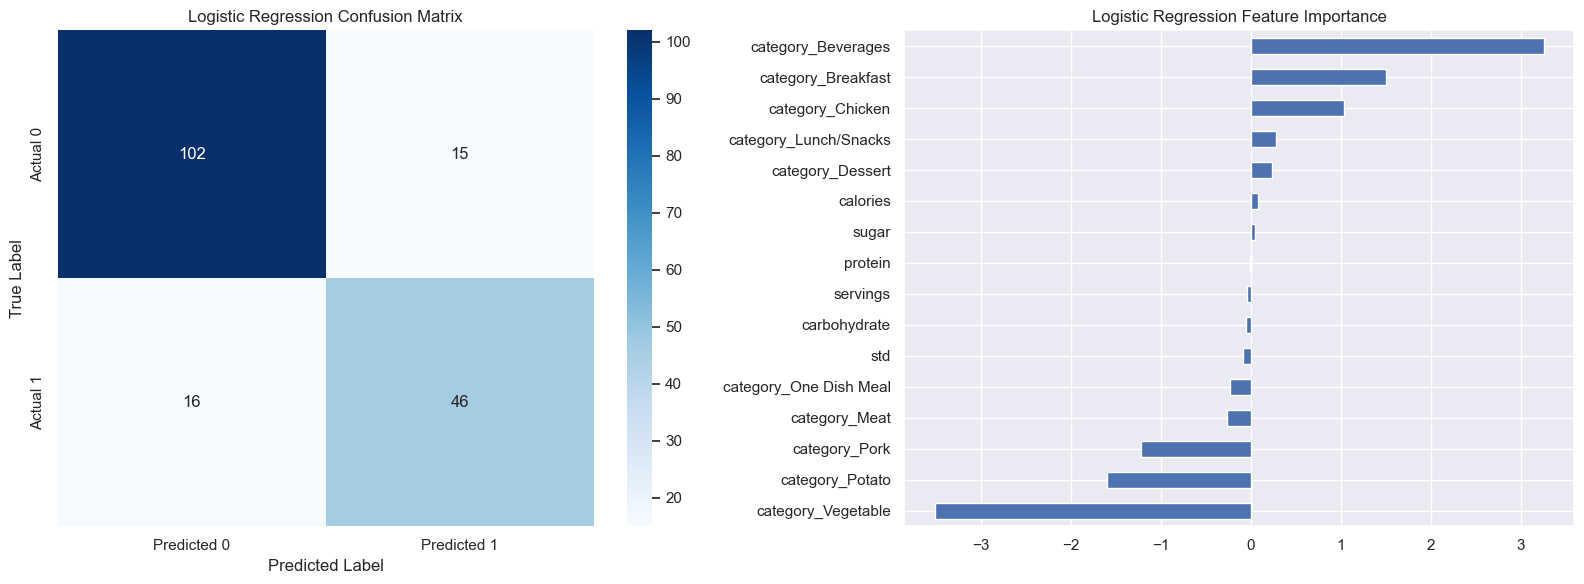

In [53]:
# Generate confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)

# Compute feature importance for Logistic Regression
importances_logistic = pd.Series(best_logistic.coef_[0], index=column_order[:-1])
sorted_importances_logistic = importances_logistic.sort_values()

# Create a combined figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Confusion matrix heatmap for Logistic Regression
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"],
            ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Logistic Regression Confusion Matrix")

# Right subplot: Logistic Regression Feature Importance
sorted_importances_logistic.plot(kind='barh', ax=axes[1])
axes[1].set_title("Logistic Regression Feature Importance")

plt.tight_layout()
plt.show()


In [54]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Best Params: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}
Best CV Score: 0.7607428001140576
Confusion Matrix:
 [[101  16]
 [ 16  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       117
           1       0.74      0.74      0.74        62

    accuracy                           0.82       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



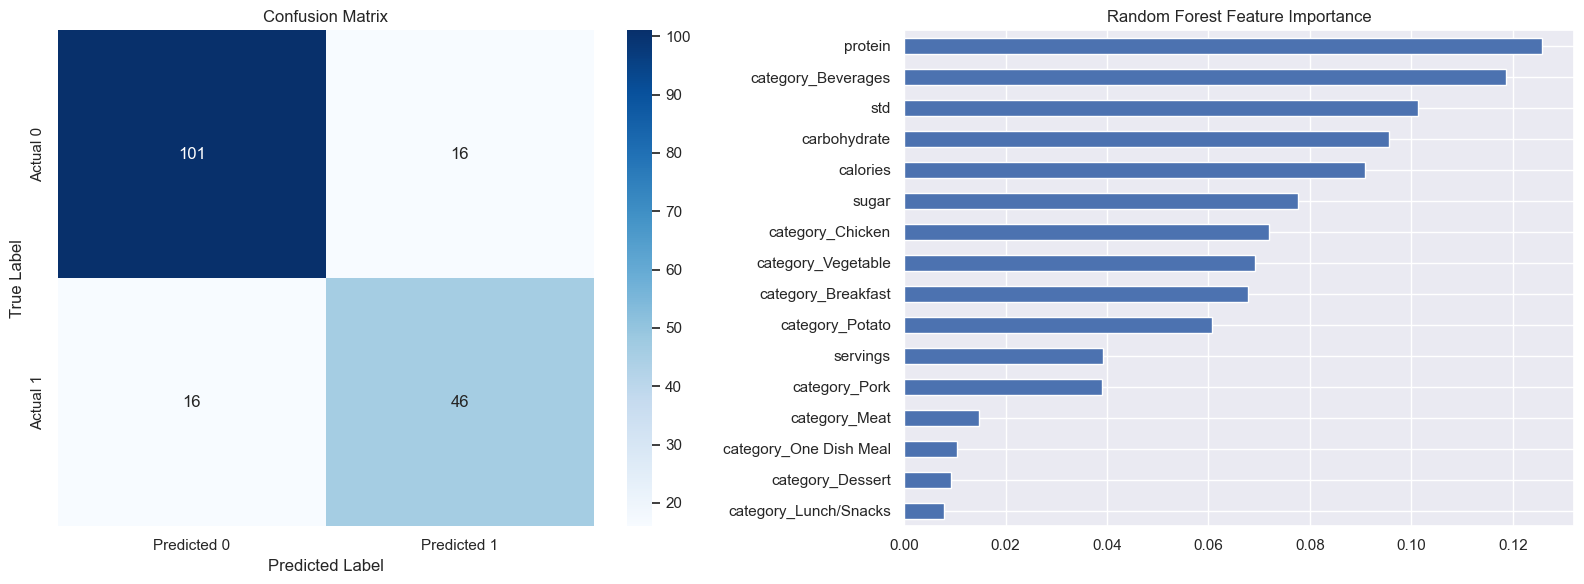

In [55]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Get feature importances from the best random forest estimator
importances_rf = pd.Series(best_rf.feature_importances_, index=df_recipes.drop('traffic', axis=1).columns)
sorted_importances_rf = importances_rf.sort_values(ascending=True)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Confusion Matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"],
            ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Confusion Matrix")

# Right subplot: Random Forest Feature Importance
sorted_importances_rf.plot(kind='barh', ax=axes[1])
axes[1].set_title("Random Forest Feature Importance")

plt.tight_layout()
plt.show()

## Business Focus & Metrics

The business has two main objectives: 
1. Accurately predict which recipes will get high traffic.
2. Be at least 80% confident when predicting a "High" traffic recipe.

Our evaluation shows that both models perform well:
- **Logistic Regression:**  
  - **Best Parameters:** {'C': 5, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
  - **Accuracy:** Approximately 83% on the test set  
  - **Weighted F1 Score:** About 0.83  
  - **AUC:** 0.88

- **Random Forest:**  
  - **Best Parameters:** {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}  
  - **Accuracy:** Approximately 82% on the test set  
  - **Weighted F1 Score:** About 0.82  
  - **AUC:** 0.87

Both models reliably identify high-traffic recipes, with each metric for both models meeting or exceeding the 80% threshold. Logistic Regression shows a slight edge in overall accuracy and AUC, while Random Forest exhibits strong performance on training data. 

Given these results, either model can be put into production to help the product team confidently predict high-traffic recipes. In practice, factors such as model interpretability and ease of deployment may also influence the final choice.

**Next Steps for Improvement:**

- **Deployment Strategy:** Evaluate the optimal method to deploy the chosen model while balancing performance and cost. Consider using edge computing for efficiency and better security.
- **Regular Model Retraining:** Establish a retraining schedule to update the model with fresh data, ensuring sustained accuracy as user behavior evolves.
- **Data Enrichment:** Enhance the dataset with additional features (e.g., preparation time, cost per serving, detailed ingredient lists, user engagement metrics) to further improve prediction performance.
- **Balance Data Categories:** Address any data imbalance—either through additional data collection for underrepresented classes or by using augmentation techniques—to maintain robust performance.

Overall, the high accuracy combined with strong AUC and F1 scores reinforce that our models are well-suited to reliably predict high-traffic recipes.

In [56]:
# Logistic Regression predictions
X_train_pred_log = best_logistic.predict(X_train)
print('Logistic Train Accuracy: ', accuracy_score(y_train, X_train_pred_log))
X_test_pred_log = best_logistic.predict(X_test)
print('Logistic Test Accuracy: ', accuracy_score(y_test, X_test_pred_log))

# Random Forest predictions using the best estimator from grid search
X_train_pred_rf = best_rf.predict(X_train)
print('Random Forest Train Accuracy: ', accuracy_score(y_train, X_train_pred_rf))
X_test_pred_rf = best_rf.predict(X_test)
print('Random Forest Test Accuracy: ', accuracy_score(y_test, X_test_pred_rf))

Logistic Train Accuracy:  0.7458100558659218
Logistic Test Accuracy:  0.8268156424581006
Random Forest Train Accuracy:  0.909217877094972
Random Forest Test Accuracy:  0.8212290502793296


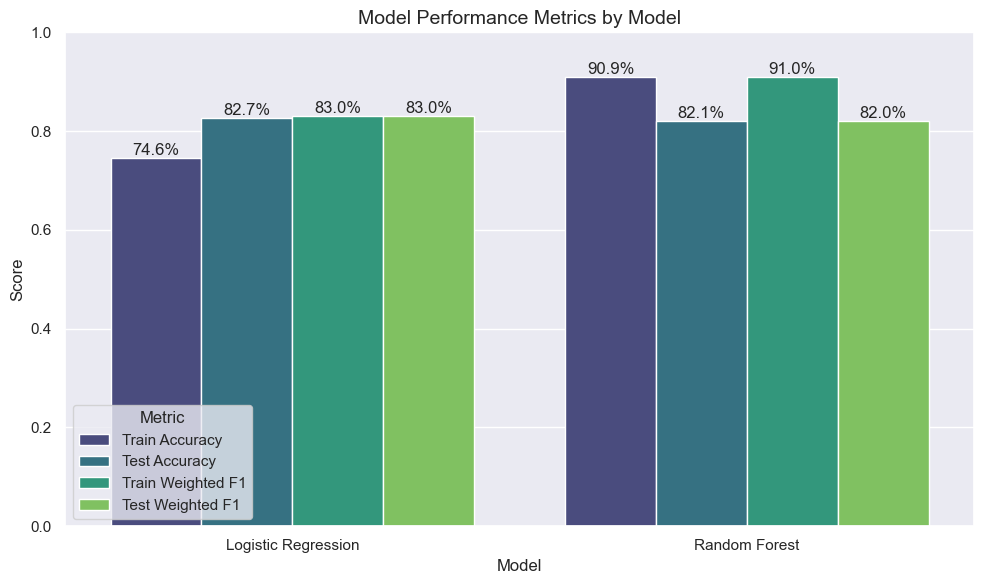

In [57]:
data = pd.DataFrame({
    'Model': ['Logistic Regression'] * 4 + ['Random Forest'] * 4,
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Train Weighted F1', 'Test Weighted F1'] * 2,
    'Score': [0.7458, 0.8268, 0.83, 0.83, 0.9092, 0.8212, 0.91, 0.82]
})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=data, palette='viridis')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics by Model', fontsize=14)
ax.set_ylim(0, 1)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f"{height*100:.1f}%", 
            ha="center", 
            va="bottom", 
            fontsize=12
        )

plt.tight_layout()
plt.show()

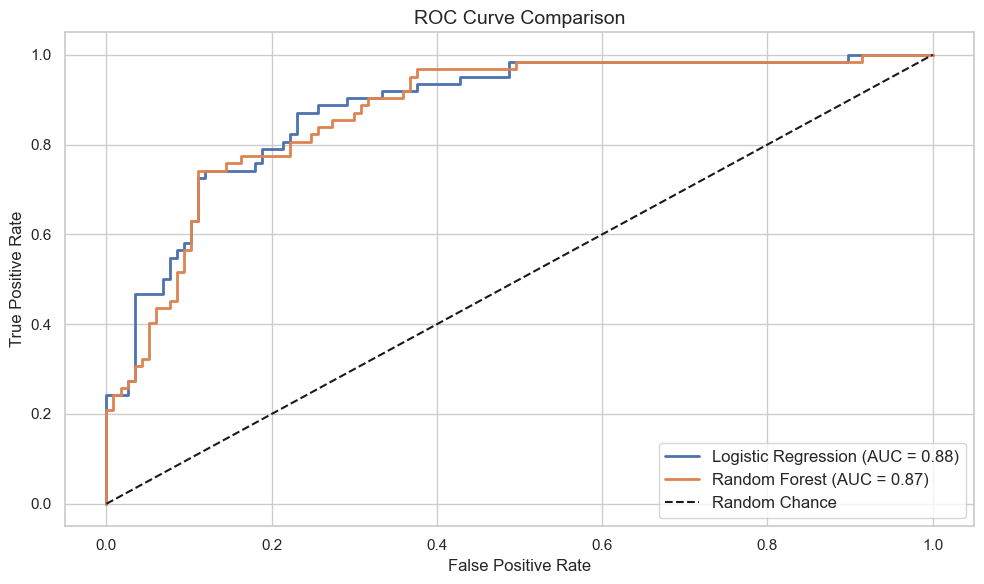

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

# Ensure seaborn style
sns.set(style='whitegrid')

# Compute predicted probabilities for class 1
y_prob_log = best_logistic.predict_proba(X_test)[:, 1]
y_prob_rf  = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve data and AUC for both models
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})', lw=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()